Подготовить данные для модели. Анализ данных, необходимые корректировки: 
1. Обработать пропуски. 

In [1]:
import re
import pymorphy2
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from scipy.stats import normaltest
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler


csv_path = 'credit_train.csv'

# read to DataFrame from csv with cp1251 encoding and ; delimeter
credit_df = pd.read_csv(csv_path, encoding='cp1251', delimiter=';')


In [2]:
# find columns which contains NaN values
def find_nans() -> None:
    nan_columns = credit_df.isna().any()
    nan_columns_list = list(nan_columns[nan_columns > 0].index)
    print('Column names with NaN values:\n', nan_columns_list)


In [3]:
print(credit_df.shape)
find_nans()


(170746, 15)
Column names with NaN values:
 ['age', 'marital_status', 'credit_sum', 'score_shk', 'education', 'living_region', 'monthly_income', 'credit_count', 'overdue_credit_count']


Мы можем обработать некоторые пропуски в колонках таблицы исходя из своих предположений. Например, пропуски в колонке "age" можем заполнить средним занчением для данного столбца, пропуски для колонки "education" - значением "absence". Чтобы обработать пропуски в столбце "credit_sum", можно предположить, что сумма кредита каким-то образом связана с месяцами кредитования ("credit_month"), тарифом ("tariff_id"), оценкой кредитанта ("score_shk"), месячным доходом ("monthly_income"), кол-вом текущих и просроченных кредитов ("credit_count", "overdue_credit_count"), следовательно, в качестве значений для заполнения пропусков можно использовать среднее значение сумм кредита из других записей с равными значениями в перечисленных колонках.

In [4]:
# fill NaN values in column "age" with mean value for this column
credit_df.age = credit_df.age.fillna(credit_df.age.mean())

# fill NaN values in column "education" with "absence" default value
credit_df.education = credit_df.education.fillna('absence')


In [5]:
# function for fill gaps in target_column based on values in dependent columns
def replace_to_average(column_name: str, dep_cols: set) -> None:
    global credit_df
    # find rows indexes with NaN in column "colunm_name"
    nan_indexes = credit_df[credit_df[column_name].isna()].index

    # iterate though rows with NaN in target column
    for i in nan_indexes:
        # find columns for current row without NaN values
        not_nan_columns = credit_df.iloc[i].isna()
        not_nan_columns_set = set(not_nan_columns[not_nan_columns == 0].index)
        # take columns from dependences columns set which non-NaNs
        item_cols = list(not_nan_columns_set.intersection(dep_cols))
        
        # create DataFrame with the same values in dependent columns list
        deps_df = credit_df[(credit_df[item_cols] == credit_df.loc[i, item_cols]).all(axis=1)]
        deps_df = deps_df.dropna(subset=item_cols + [column_name])

        if deps_df.empty:
            continue

        # gake mean values from result DataFrame for target column
        credit_df.loc[i, [column_name]] = deps_df[column_name].mean()

    # exclude rows with NaNs in target column if they weren't replaced
    credit_df = credit_df.dropna(subset=column_name)


In [6]:
# columns that dependent with "credit_sum" column
sum_dep_cols = {'credit_month', 'tariff_id', 'score_shk', 'monthly_income', 'credit_count', 'overdue_credit_count'}

# replace symbol ',' to ',' for convert column values to float
columns_to_float = ['credit_sum', 'score_shk']
credit_df[columns_to_float] = credit_df[columns_to_float].apply(lambda x: x.str.replace(',', '.').astype(float))

# call function for replace NaN values in "credit_sum" column
replace_to_average('credit_sum', sum_dep_cols)


In [7]:
find_nans()


Column names with NaN values:
 ['marital_status', 'score_shk', 'living_region', 'monthly_income', 'credit_count', 'overdue_credit_count']


Можно заполнять оставшиеся пропуски аналогично пропускам в колонке "credit_sum", опираясь на средние значения других записей, однако при выделении связанных с нужным столбцов можно в итоге получить среди этих них те, что были также заполнены средниими значениями. Такой метод может в итоге испортить всю статистику и получится более трудоемким, чем исключение строк со значениями NaN из таблицы.

In [8]:
credit_df = credit_df.dropna()
find_nans()
print(credit_df.shape)


Column names with NaN values:
 []
(161333, 15)


2. Оценить выбросы. 

In [9]:
# function for analyse emission values outside intervals [mean - 3std; mean + 3std] for each numeric column
def emission_analysis(df: pd.DataFrame, numeric_columns: list) -> None:
    numeric_3std_intervals = pd.DataFrame({'lower': df[numeric_columns].mean() - df[numeric_columns].std() * 3, 
                                            'upper': df[numeric_columns].mean() + df[numeric_columns].std() * 3}, 
                                            columns=['lower', 'upper'], index=numeric_columns)

    print('Total records count is', len(df))
    for col in numeric_columns:
        lower_border, upper_border = numeric_3std_intervals.loc[col]
        emissions_count = len(df[(lower_border > df[col]) | (df[col] > upper_border)])
        print('Emissions count for column', col, 'is', emissions_count)


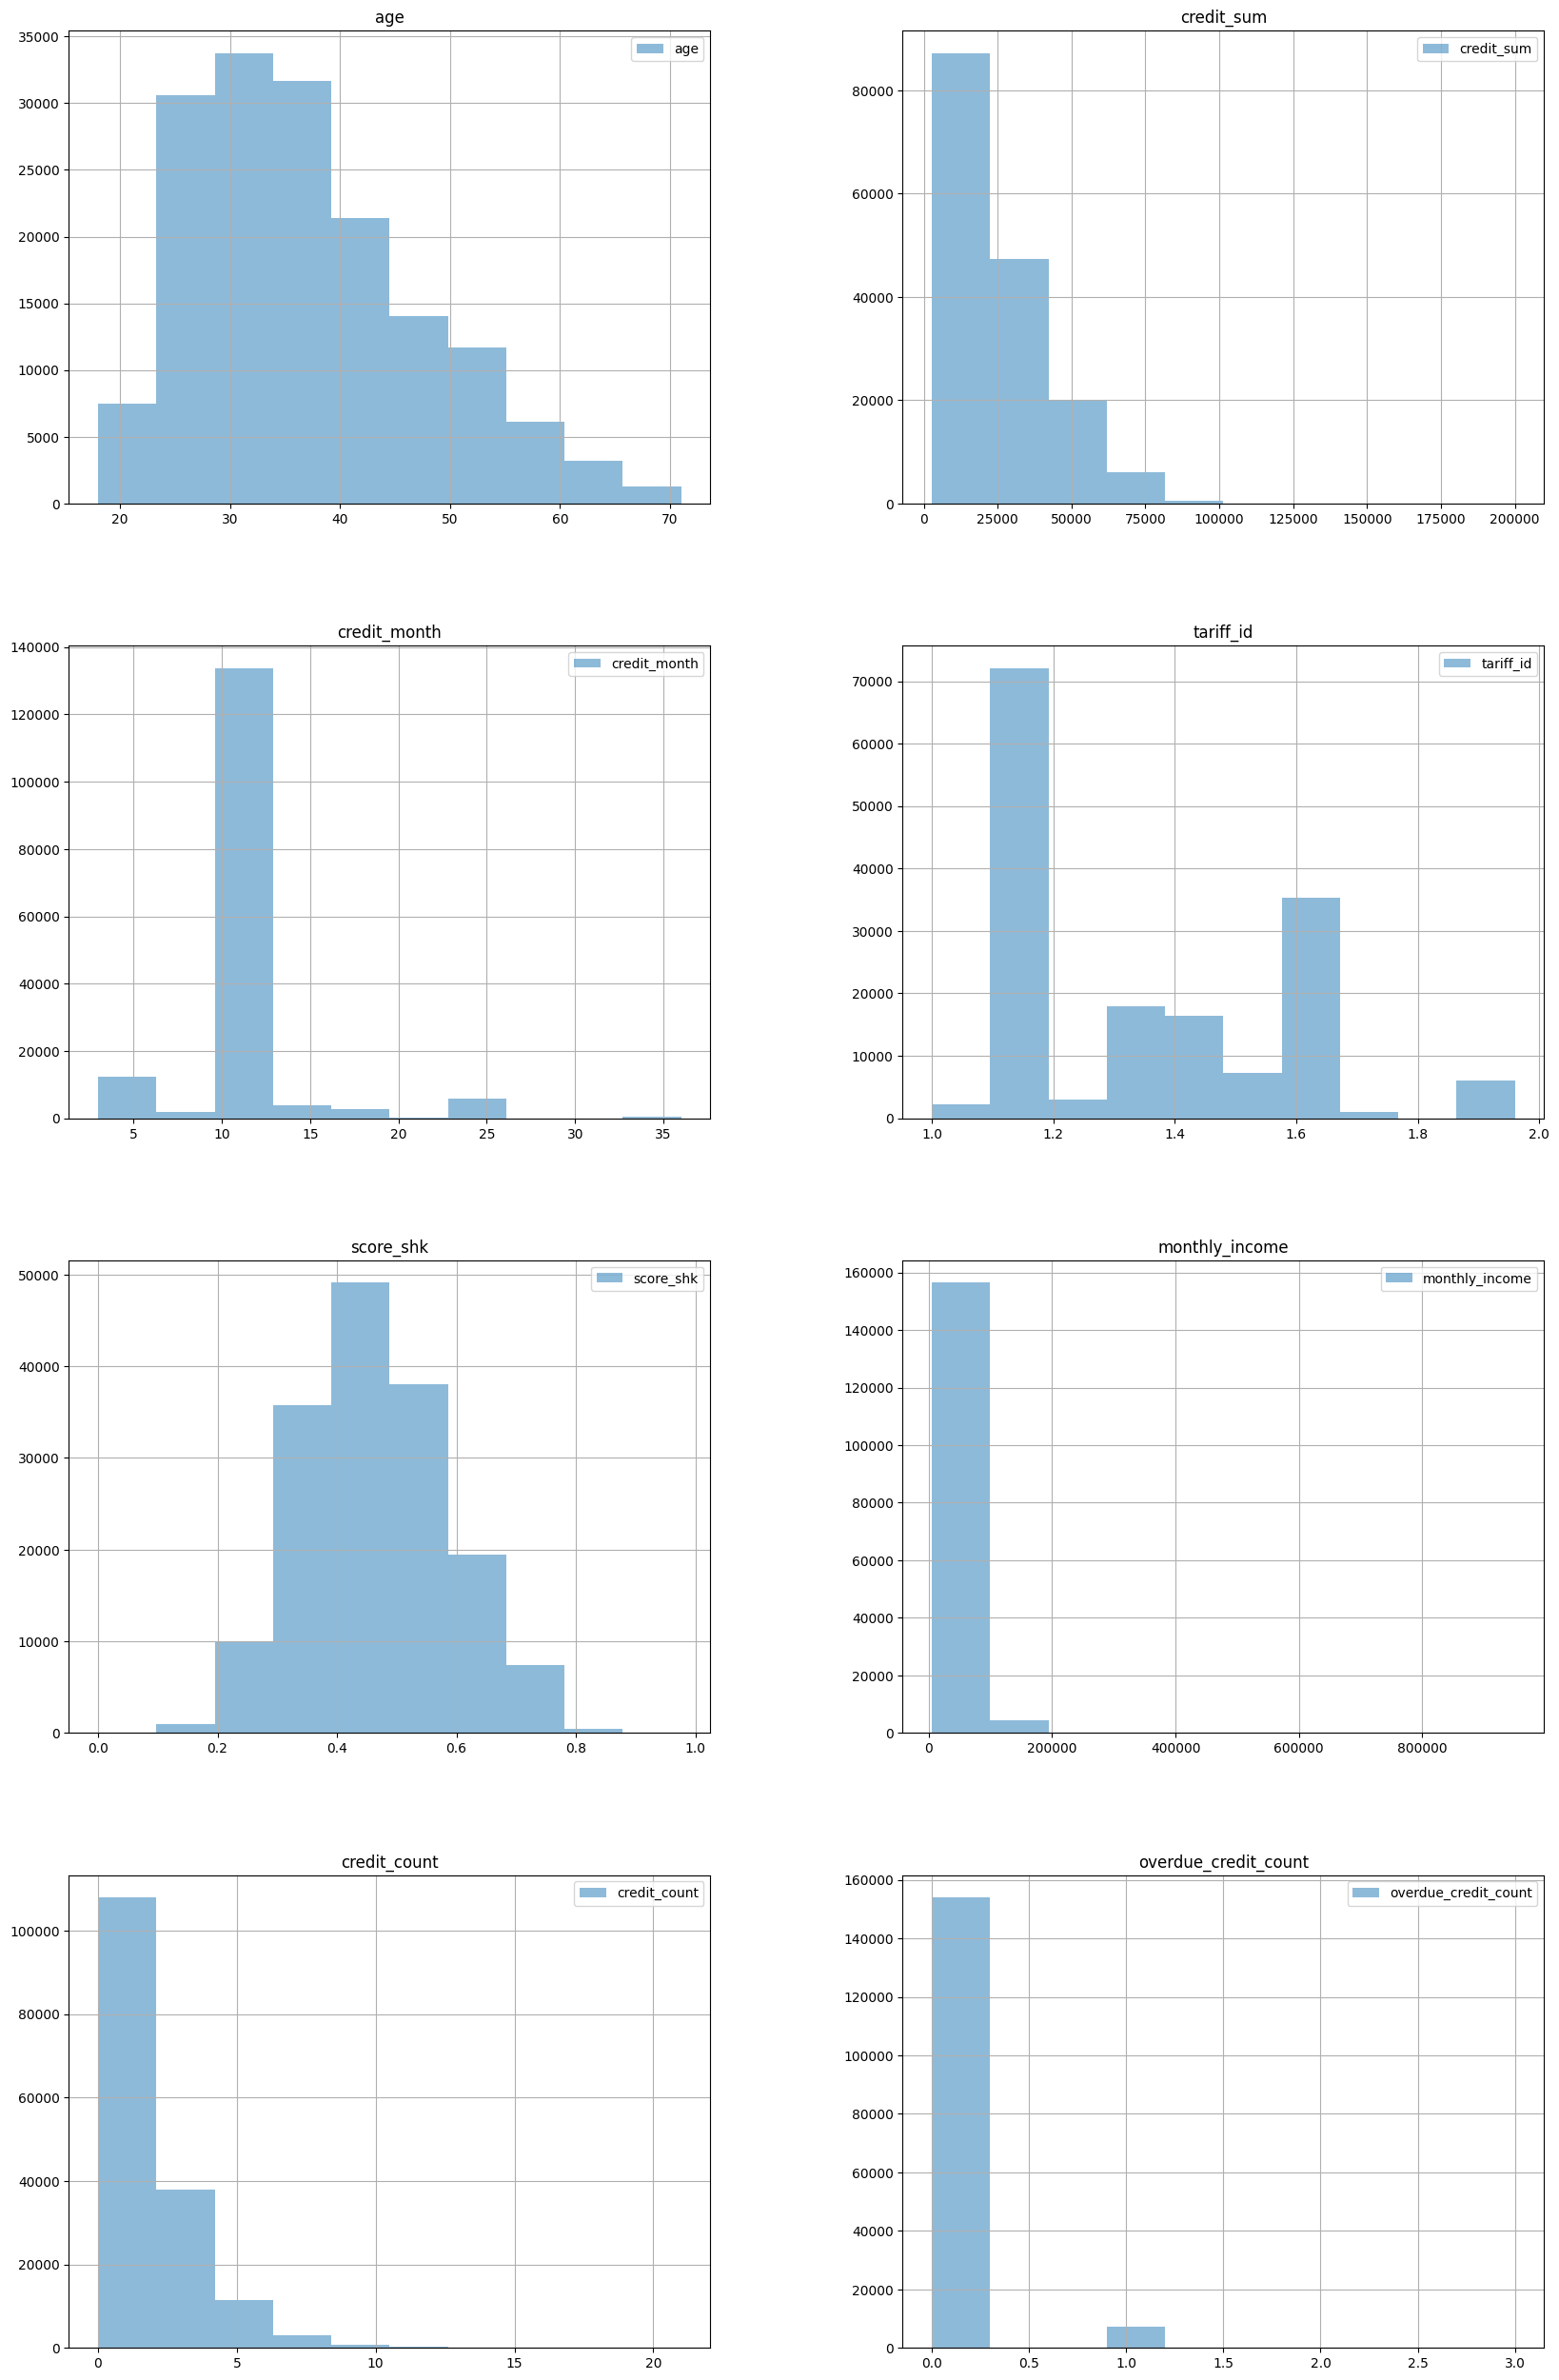

Total records count is 161333
Emissions count for column age is 346
Emissions count for column credit_sum is 1808
Emissions count for column credit_month is 6371
Emissions count for column tariff_id is 0
Emissions count for column score_shk is 118
Emissions count for column monthly_income is 2224
Emissions count for column credit_count is 1982
Emissions count for column overdue_credit_count is 7372


In [10]:
NUMERIC_COLUMNS = ['age', 'credit_sum', 'credit_month', 'tariff_id', 'score_shk', 'monthly_income', 
                   'credit_count', 'overdue_credit_count']
credit_df[NUMERIC_COLUMNS].hist(layout=(5, 2), figsize=(20, 40), bins=10, alpha=0.5, grid=True, legend=True) 
plt.show()

emission_analysis(credit_df, NUMERIC_COLUMNS)

3. Корреляция. 

Приведем колонку "living_region" к нормальномуу виду. На данный момент в ней 289 уникальных записей, однако большинство из них отличается приписками "Г", "ОБЛ", "РЕСП" и т п. К отличиям относятся перестановки слов в записи региона, их полные и неполные названия, формы слов и обозначение региона его номером.

In [11]:
print('"living_region" records unique count -', len(credit_df['living_region'].unique()))


"living_region" records unique count - 298


In [12]:
WASTE_WORDS = ['ОБЛАСТЬ', 'АОБЛ', 'ОБЛ', 'КРАЙ', 'ФЕДЕРАЛЬНЫЙ ОКРУГ', ' Г', 'Г ', 'Р-Н', ' АО', 'АО ', 'РЕСПУБЛИКА', 'РЕСП', '/', '.']


In [13]:
# function for simplify region records by deleting waste words as "Г", "ОБЛ", "РЕСП", etc
def simplify_region(source_region: str) -> str:
    global WASTE_WORDS

    for word in WASTE_WORDS:
        if word in source_region:
            source_region = source_region.replace(word, '')

    source_region = source_region.replace('-', ' ')
    return re.sub(r'[\s]{2,}', ' ', source_region.strip())     # delete extra spaces


In [14]:
# function for evaluating two words
def is_same_records(record1_words: list, record2_words: list) -> bool:
    SAMENESS_TH = 0.49

    min_words_count = min(len(record1_words), len(record2_words))
    # find count of same words in two records
    same_words_count = len(set(record1_words).intersection(set(record2_words)))

    # check if same words count upper some sameness threshold and if record not in created dictionary
    if same_words_count * 1. / min_words_count > SAMENESS_TH:
        return True

    return False


In [15]:
# funcdion for find same region records if they are just rearrangement or tranceted
def find_same_after_rearrangement(target_column: str) -> dict:
    replace_dict = dict()
    # take only complex records
    complex_regions = [item.split() for item in credit_df[target_column].unique() if ' ' in item]
    complex_regions.sort()

    for i in range(len(complex_regions)):
        for j in range(i + 1, len(complex_regions)):
            if is_same_records(complex_regions[i], complex_regions[j]) and \
                    ' '.join(complex_regions[j]) not in replace_dict.keys():
                replace_dict[' '.join(complex_regions[j])] = ' '.join(complex_regions[i])

    return replace_dict


In [16]:
# initialize MorphAnalyzer to get words normal form 
morph = pymorphy2.MorphAnalyzer()


In [17]:
# function to safe get word normal form, otherwise return source word 
def get_base_form(word: str) -> str:
    global morph

    try:
        return morph.parse(word)[0].normal_form.upper()     # return in uppercase to simplify comparison
    except:
        return word


In [18]:
# find tranceted and extended region names
# find region names with letters permutations
# find region names in different morphological forms

def find_same_regions(target_column: str) -> dict:
    replace_dict = dict()
    unique_regions_list = credit_df[target_column].unique()
    unique_regions_list.sort()

    for unique_region1 in unique_regions_list:
        for unique_region2 in unique_regions_list:
            if unique_region1 == unique_region2 or unique_region2 in replace_dict.values():
                continue

            if ' ' in unique_region2:
                region_words = unique_region2.split()
                if unique_region1 in region_words:
                    replace_dict[unique_region2] = unique_region1

            elif len(unique_region1) == len(unique_region2) and set(unique_region1) == set(unique_region2):
                replace_dict[unique_region2] = unique_region1

            elif get_base_form(unique_region2) == unique_region1:
                replace_dict[unique_region2] = unique_region1

    return replace_dict


In [19]:
# function for replace region records according to dictionaries
def replace_region(source_region: str, replace_regions_dict: dict) -> str:
    if source_region in replace_regions_dict.keys():
        return replace_regions_dict[source_region]

    return source_region


In [20]:
target_column = 'living_region'

# remove waste words from region records
credit_df[target_column] = credit_df[target_column].apply(simplify_region)

# create dictionaries for replace same records
replace_dict1 = find_same_after_rearrangement(target_column)
replace_dict2 = find_same_regions(target_column)
replace_dict3 = {'74': 'ЧЕЛЯБИНСКАЯ', '98': 'САНКТ ПЕТЕРБУРГ'}

credit_df[target_column] = credit_df[target_column].apply(replace_region, replace_regions_dict=(replace_dict1 | replace_dict2 | replace_dict3))


По выводу ячейки видно, что кол-во уникальных названий регионов сократилось до 90 записей. Среди них есть похожие меджу собой записи, такие как название регионального центра и регион этого города, однако георгафически это практически разные вещи, поэтому можно не обрабатывать эту колонку дальше.

In [21]:
unique_list = credit_df[target_column].unique()
unique_list.sort()

print(unique_list, '\n\n"living_region" records unique count -', len(unique_list))


['АДЫГЕЯ' 'АЛТАЙ' 'АЛТАЙСКИЙ' 'АМУРСКАЯ' 'АРХАНГЕЛЬСКАЯ' 'АСТРАХАНСКАЯ'
 'БАШКОРТОСТАН' 'БЕЛГОРОДСКАЯ' 'БРЯНСКИЙ' 'БУРЯТИЯ' 'ВЛАДИМИРСКАЯ'
 'ВОЛГОГРАДСКАЯ' 'ВОЛОГОДСКАЯ' 'ВОРОНЕЖСКАЯ' 'Г МОСКВА'
 'Г САНКТ ПЕТЕРБУРГ' 'ГОРЬКОВСКАЯ' 'ГУСЬ ХРУСТАЛЬНЫЙ' 'ДАГЕСТАН'
 'ЕВРЕЙСКАЯ' 'ЗАБАЙКАЛЬСКИЙ' 'ИВАНОВСКАЯ' 'ИНГУШЕТИЯ' 'ИРКУТСКАЯ'
 'КАБАРДИНО БАЛКАРСКАЯ' 'КАЛИНИНГРАДСКАЯ' 'КАЛМЫКИЯ' 'КАЛУЖСКАЯ'
 'КАМЧАТСКИЙ' 'КАРАЧАЕВО ЧЕРКЕССКАЯ' 'КАРЕЛИЯ' 'КЕМЕРОВСКАЯ' 'КИРОВСКАЯ'
 'КОМИ' 'КОСТРОМСКАЯ' 'КРАСНОДАРСКИЙ' 'КРАСНОЯРСКИЙ' 'КУРГАНСКАЯ'
 'КУРСКАЯ' 'ЛЕНИНГРАДСКАЯ' 'ЛИПЕЦКАЯ' 'МАГАДАНСКАЯ' 'МАРИЙ ЭЛ' 'МОРДОВИЯ'
 'МОСКВА' 'МОСКВОСКАЯ' 'МУРМАНСКАЯ' 'МЫТИЩИНСКИЙ' 'НЕНЕЦКИЙ'
 'НИЖЕГОРОДСКАЯ' 'НОВГОРОДСКАЯ' 'НОВОСИБИРСКАЯ' 'ОМСКАЯ' 'ОРЁЛ'
 'ОРЕНБУРГСКАЯ' 'ОРЛОВСКАЯ' 'ПЕНЗЕНСКАЯ' 'ПЕРМСКИЙ' 'ПРИВОЛЖСКИЙ'
 'ПРИМОРСКИЙ' 'ПСКОВСКАЯ' 'РОССИЯ' 'РОСТОВСКАЯ' 'РЯЗАНСКАЯ' 'САМАРСКАЯ'
 'САНКТ ПЕТЕРБУРГ' 'САРАТОВСКАЯ' 'САХА' 'САХАЛИНСКАЯ' 'СВЕРДЛОВСКАЯ'
 'СЕВ ОСЕТИЯ АЛАНИЯ' 'СМОЛЕНСКАЯ' 'СТАВРОПОЛЬСКИЙ' 'ТАМБОВСКАЯ'


Для построения кореляции объединим города по федеральным округам. В папку положим csv-файл, содержащий колонку с названием географического субъекта ('subject') и колонку с соответствующим ему федеральным округом ('district'). Информация взята с таблицы сайта <a href="https://ru.wikipedia.org/wiki/%D0%9F%D0%BB%D0%BE%D1%89%D0%B0%D0%B4%D1%8C_%D1%81%D1%83%D0%B1%D1%8A%D0%B5%D0%BA%D1%82%D0%BE%D0%B2_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B9%D1%81%D0%BA%D0%BE%D0%B9_%D0%A4%D0%B5%D0%B4%D0%B5%D1%80%D0%B0%D1%86%D0%B8%D0%B8">Википедия</a>.

In [22]:
dictionary_file = 'Districts_dictionary.csv'
districts_df = pd.read_csv(dictionary_file)
print(districts_df)


                       subject         district
0     Республика Саха (Якутия)  Дальневосточный
1             Хабаровский край  Дальневосточный
2   Чукотский автономный округ  Дальневосточный
3              Камчатский край  Дальневосточный
4          Магаданская область  Дальневосточный
..                         ...              ...
80         Республика Калмыкия            Южный
81        Астраханская область            Южный
82             Республика Крым            Южный
83           Республика Адыгея            Южный
84                 Севастополь            Южный

[85 rows x 2 columns]


In [23]:
# make all records in table uppercase as in our work table with credit information
districts_df = districts_df.apply(lambda x: x.str.upper())

# make subject items simply as in 'living_region' column of credit table
districts_df['subject'] = districts_df['subject'].apply(simplify_region)
print(districts_df)


                       subject         district
0                САХА (ЯКУТИЯ)  ДАЛЬНЕВОСТОЧНЫЙ
1                  ХАБАРОВСКИЙ  ДАЛЬНЕВОСТОЧНЫЙ
2   ЧУКОТСКИЙ АВТОНОМНЫЙ ОКРУГ  ДАЛЬНЕВОСТОЧНЫЙ
3                   КАМЧАТСКИЙ  ДАЛЬНЕВОСТОЧНЫЙ
4                  МАГАДАНСКАЯ  ДАЛЬНЕВОСТОЧНЫЙ
..                         ...              ...
80                    КАЛМЫКИЯ            ЮЖНЫЙ
81                АСТРАХАНСКАЯ            ЮЖНЫЙ
82                        КРЫМ            ЮЖНЫЙ
83                      АДЫГЕЯ            ЮЖНЫЙ
84                 СЕВАСТОПОЛЬ            ЮЖНЫЙ

[85 rows x 2 columns]


In [24]:
# create dictionary from district DataFrame columns to simplify search
target_regions_dict = dict(zip(districts_df['subject'].tolist(), districts_df['district'].tolist()))
print(target_regions_dict)


{'САХА (ЯКУТИЯ)': 'ДАЛЬНЕВОСТОЧНЫЙ', 'ХАБАРОВСКИЙ': 'ДАЛЬНЕВОСТОЧНЫЙ', 'ЧУКОТСКИЙ АВТОНОМНЫЙ ОКРУГ': 'ДАЛЬНЕВОСТОЧНЫЙ', 'КАМЧАТСКИЙ': 'ДАЛЬНЕВОСТОЧНЫЙ', 'МАГАДАНСКАЯ': 'ДАЛЬНЕВОСТОЧНЫЙ', 'ЗАБАЙКАЛЬСКИЙ': 'ДАЛЬНЕВОСТОЧНЫЙ', 'АМУРСКАЯ': 'ДАЛЬНЕВОСТОЧНЫЙ', 'БУРЯТИЯ': 'ДАЛЬНЕВОСТОЧНЫЙ', 'ПРИМОРСКИЙ': 'ДАЛЬНЕВОСТОЧНЫЙ', 'САХАЛИНСКАЯ': 'ДАЛЬНЕВОСТОЧНЫЙ', 'ЕВРЕЙСКАЯ АВТОНОМНАЯ': 'ДАЛЬНЕВОСТОЧНЫЙ', 'ПЕРМСКИЙ': 'ПРИВОЛЖСКИЙ', 'БАШКОРТОСТАН': 'ПРИВОЛЖСКИЙ', 'ОРЕНБУРГСКАЯ': 'ПРИВОЛЖСКИЙ', 'КИРОВСКАЯ': 'ПРИВОЛЖСКИЙ', 'САРАТОВСКАЯ': 'ПРИВОЛЖСКИЙ', 'НИЖЕГОРОДСКАЯ': 'ПРИВОЛЖСКИЙ', 'ТАТАРСТАН': 'ПРИВОЛЖСКИЙ', 'САМАРСКАЯ': 'ПРИВОЛЖСКИЙ', 'ПЕНЗЕНСКАЯ': 'ПРИВОЛЖСКИЙ', 'УДМУРТСКАЯ': 'ПРИВОЛЖСКИЙ', 'УЛЬЯНОВСКАЯ': 'ПРИВОЛЖСКИЙ', 'МОРДОВИЯ': 'ПРИВОЛЖСКИЙ', 'МАРИЙ ЭЛ': 'ПРИВОЛЖСКИЙ', 'ЧУВАШСКАЯ': 'ПРИВОЛЖСКИЙ', 'КОМИ': 'СЕВЕРО-ЗАПАДНЫЙ', 'АРХАНГЕЛЬСКАЯ': 'СЕВЕРО-ЗАПАДНЫЙ', 'КАРЕЛИЯ': 'СЕВЕРО-ЗАПАДНЫЙ', 'НЕНЕЦКИЙ АВТОНОМНЫЙ ОКРУГ': 'СЕВЕРО-ЗАПАДНЫЙ', 'МУРМАНСКАЯ': 'СЕВЕРО-ЗАПАДНЫЙ', 'ВОЛОГОДСКАЯ': 'СЕВЕРО-ЗАПА

In [25]:
# function for find district for all geographical subjects from 'living_region' in credit data table 
def find_district(source_region: str):
    global target_regions_dict

    # search district in subjects keys
    if source_region in target_regions_dict.keys():
        return target_regions_dict[source_region]

    # analyze if living region name in tranceted or extended but same with some subject in district dictionary
    for target_region in target_regions_dict.keys():
        if is_same_records(source_region.split(), target_region.split()):
            return target_regions_dict[target_region]

    # analyze if region name is morphological form and normal form is in district dictionary keys
    source_morph = get_base_form(source_region)
    if source_morph in target_regions_dict.keys():
        return target_regions_dict[source_morph]

    # analyze if region name in district dictionary keys is morphological form and normal form is the same with living region name
    # this circle at the end of the function because it is less likely case and we hope, we won't check it often
    for target_region in target_regions_dict.keys():
        if source_region == get_base_form(target_region):
            return target_regions_dict[target_region]

    # less likely case if living region name is the same with federal district
    if source_region in set(target_regions_dict.values()):
        return source_region

    # extend regions dictionary with key 'OTHER'
    target_regions_dict[source_region] = 'OTHER'

    return 'OTHER'


Заменяем названия регионов из таблицы о кредитах на названия федеральных округов РФ. В результате все записи, кроме 42, были сгруппированы по округам. Относительно всех записей число 42 маленькое, оставим эти записи в категории 'OTHER'.

In [26]:
print('Total records count is', len(credit_df))
find_nans()


Total records count is 161333
Column names with NaN values:
 []


In [27]:
# replace living_region names with federal district names
credit_df['living_region'] = credit_df['living_region'].apply(find_district)
print(credit_df['living_region'].value_counts())


living_region
ПРИВОЛЖСКИЙ          34351
ЦЕНТРАЛЬНЫЙ          24598
СЕВЕРО-ЗАПАДНЫЙ      22870
УРАЛЬСКИЙ            19591
ЮЖНЫЙ                17590
СИБИРСКИЙ            14848
OTHER                11972
ДАЛЬНЕВОСТОЧНЫЙ       9403
СЕВЕРО-КАВКАЗСКИЙ     6110
Name: count, dtype: int64


In [28]:
# encode non-numeric columns
LABEL_ENCODING_COLUMNS = ['gender', 'marital_status', 'job_position', 'education']
HOT_ENCODING_COLUMNS = ['living_region']

label_encoder = LabelEncoder()
hot_encoder = OneHotEncoder(sparse_output=False)

for column in LABEL_ENCODING_COLUMNS:
    credit_df[column] = label_encoder.fit_transform(credit_df[column])

one_hot_encoded = hot_encoder.fit_transform(credit_df[HOT_ENCODING_COLUMNS])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=hot_encoder.get_feature_names_out(HOT_ENCODING_COLUMNS), index=credit_df.index)
credit_df = pd.concat([credit_df, one_hot_df], axis=1)
credit_df = credit_df.drop(HOT_ENCODING_COLUMNS, axis=1)

print('Total records count is', len(credit_df))
print('With new columns:\n', credit_df.columns)


Total records count is 161333
With new columns:
 Index(['client_id', 'gender', 'age', 'marital_status', 'job_position',
       'credit_sum', 'credit_month', 'tariff_id', 'score_shk', 'education',
       'monthly_income', 'credit_count', 'overdue_credit_count',
       'open_account_flg', 'living_region_OTHER',
       'living_region_ДАЛЬНЕВОСТОЧНЫЙ', 'living_region_ПРИВОЛЖСКИЙ',
       'living_region_СЕВЕРО-ЗАПАДНЫЙ', 'living_region_СЕВЕРО-КАВКАЗСКИЙ',
       'living_region_СИБИРСКИЙ', 'living_region_УРАЛЬСКИЙ',
       'living_region_ЦЕНТРАЛЬНЫЙ', 'living_region_ЮЖНЫЙ'],
      dtype='object')


In [29]:
# create correlation DataFrame
correlation_df = credit_df.corr()
correlation_df


,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,...,open_account_flg,living_region_OTHER,living_region_ДАЛЬНЕВОСТОЧНЫЙ,living_region_ПРИВОЛЖСКИЙ,living_region_СЕВЕРО-ЗАПАДНЫЙ,living_region_СЕВЕРО-КАВКАЗСКИЙ,living_region_СИБИРСКИЙ,living_region_УРАЛЬСКИЙ,living_region_ЦЕНТРАЛЬНЫЙ,living_region_ЮЖНЫЙ
client_id,1.000000,0.003041,-0.000518,0.001113,0.000784,-0.002370,-0.000382,0.000140,0.001572,0.001201,...,0.001884,-0.004958,0.005899,-0.001670,-0.001823,-0.006146,0.006882,0.002914,-0.001767,0.000333
gender,0.003041,1.000000,-0.129887,0.013812,-0.021151,0.035430,0.002927,0.012091,-0.015327,0.070390,...,0.035199,0.026337,-0.016616,0.002767,0.002984,-0.007488,-0.020284,-0.008672,0.018659,-0.005665
age,-0.000518,-0.129887,1.000000,-0.090509,-0.119831,-0.084534,0.007075,-0.100744,-0.139730,0.052999,...,0.005156,-0.008208,0.010146,-0.004665,-0.003911,0.005343,0.012424,0.008544,-0.013816,0.001966
marital_status,0.001113,0.013812,-0.090509,1.000000,0.011759,0.031617,-0.003146,0.035866,0.071053,0.018287,...,0.016264,-0.001968,0.005405,-0.005676,0.012937,-0.002960,-0.004404,-0.006121,0.006113,-0.004169
job_position,0.000784,-0.021151,-0.119831,0.011759,1.000000,-0.051779,-0.009944,0.003595,0.003606,-0.001791,...,-0.030538,0.008501,0.008375,0.004071,0.028495,-0.028341,-0.005026,0.017224,-0.009464,-0.035796
credit_sum,-0.002370,0.035430,-0.084534,0.031617,-0.051779,1.000000,0.229230,0.091513,0.048725,-0.174783,...,-0.077301,0.064624,0.035439,-0.058909,0.052921,0.025147,-0.058985,-0.048271,0.014734,0.010065
credit_month,-0.000382,0.002927,0.007075,-0.003146,-0.009944,0.229230,1.000000,-0.050180,0.042571,-0.012742,...,0.022451,-0.014266,0.025995,0.008004,0.013837,0.037949,-0.021870,-0.038243,-0.028454,0.036395
tariff_id,0.000140,0.012091,-0.100744,0.035866,0.003595,0.091513,-0.050180,1.000000,0.383109,0.064098,...,-0.072430,0.002670,-0.003190,-0.008517,0.018095,0.040647,-0.020613,-0.001647,-0.003434,-0.009000
score_shk,0.001572,-0.015327,-0.139730,0.071053,0.003606,0.048725,0.042571,0.383109,1.000000,0.250842,...,0.037787,-0.016645,0.020197,-0.001880,-0.052281,-0.027194,0.032146,0.009845,-0.004918,0.041989
education,0.001201,0.070390,0.052999,0.018287,-0.001791,-0.174783,-0.012742,0.064098,0.250842,1.000000,...,0.062879,-0.016953,0.007024,-0.001951,-0.009006,-0.044431,0.031678,0.036032,-0.002087,-0.015905


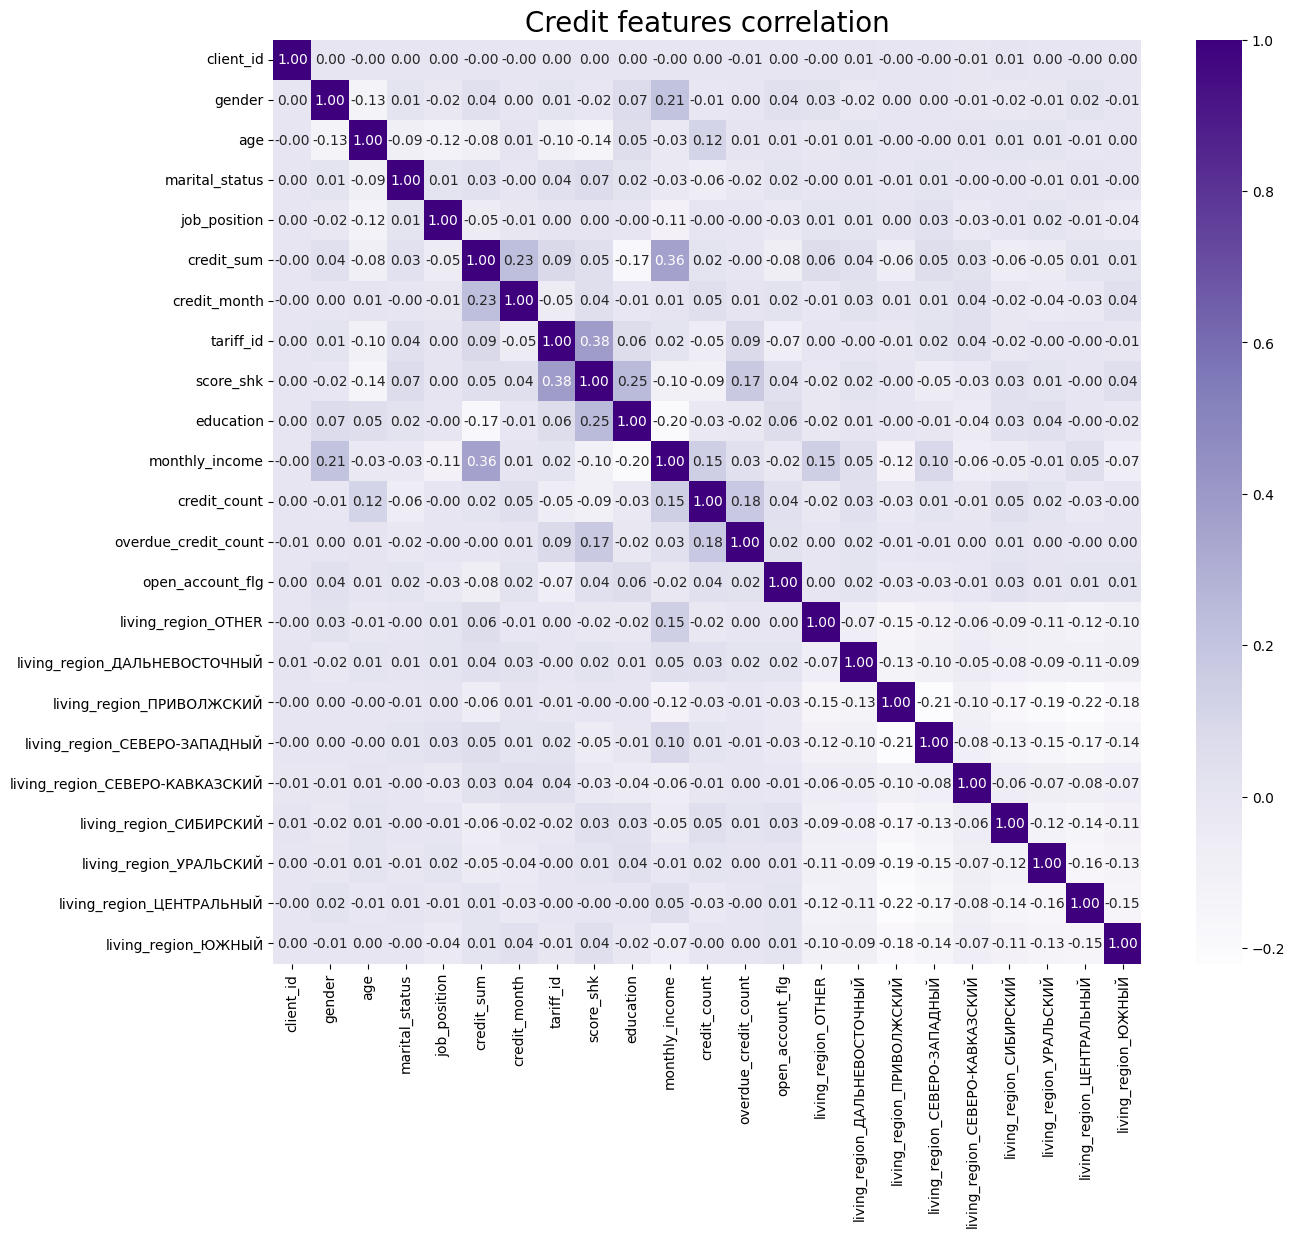

In [30]:
# show correlation heatmap
plt.figure(figsize=(14, 12))
sb.heatmap(correlation_df, xticklabels=correlation_df.columns, yticklabels=correlation_df.columns, annot=True, 
           fmt='.2f', cmap="Purples")

plt.title('Credit features correlation', fontsize=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


Как видно из тепловой карты, слабая корреляция наблюдается между столбцами "tariff_id" и "score_shk", "credit_sum" и "monthly_income", "score_shk" и "education", "credit_sum" и "credit_month", "gender" и "monthly_income". Для последней пары признаков взаимосвязь сомнительна, для остальных пар можно найти логическую взаимосвязь.

4. Тест на нормальность распределения.

In [31]:
# check if distribution is normal with Pirson criterion
ALPHA = 0.05

print('PIRSON TEST for numeric columns')
for column in NUMERIC_COLUMNS:
    statistic, p = normaltest(credit_df[column], axis=None)
    
    print('Column', column, '\n\tStatistic value -', round(statistic, 2), 'probability -', p, end='')
    print('\tNORMAL' if p > ALPHA else '\tUBNORMAL')


PIRSON TEST for numeric columns
Column age 
	Statistic value - 11764.32 probability - 0.0	UBNORMAL
Column credit_sum 
	Statistic value - 44169.37 probability - 0.0	UBNORMAL
Column credit_month 
	Statistic value - 96310.12 probability - 0.0	UBNORMAL
Column tariff_id 
	Statistic value - 18165.65 probability - 0.0	UBNORMAL
Column score_shk 
	Statistic value - 2051.38 probability - 0.0	UBNORMAL
Column monthly_income 
	Statistic value - 176529.74 probability - 0.0	UBNORMAL
Column credit_count 
	Statistic value - 41792.29 probability - 0.0	UBNORMAL
Column overdue_credit_count 
	Statistic value - 141976.5 probability - 0.0	UBNORMAL


Распределения величин числовых столбцов не являются нормальными, как видно из значений вероятности p и графиков распределения выше.

5. Масштабировать данные.

In [32]:
# normalize values to range [-1, 1] though MinMaxScaler

min_max_scaller = MinMaxScaler(feature_range=(-1, 1))
scaled_arrs = min_max_scaller.fit_transform(credit_df)

# create scaled DataFrame from scaled feature arrays 
scaled_df = pd.DataFrame(scaled_arrs, columns=credit_df.columns, index=credit_df.index)
scaled_df


,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,...,open_account_flg,living_region_OTHER,living_region_ДАЛЬНЕВОСТОЧНЫЙ,living_region_ПРИВОЛЖСКИЙ,living_region_СЕВЕРО-ЗАПАДНЫЙ,living_region_СЕВЕРО-КАВКАЗСКИЙ,living_region_СИБИРСКИЙ,living_region_УРАЛЬСКИЙ,living_region_ЦЕНТРАЛЬНЫЙ,living_region_ЮЖНЫЙ
7,-1.000000,-1.0,-0.698113,0.5,0.5,-0.542319,-0.575758,-0.791667,0.050121,-0.6,...,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
9,-0.999977,-1.0,-0.471698,0.5,0.5,-0.761416,-0.575758,-0.791667,-0.047201,-0.6,...,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0
10,-0.999965,1.0,-0.698113,0.0,0.5,-0.857480,-0.333333,-1.000000,-0.087351,0.2,...,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0
11,-0.999953,-1.0,-0.698113,0.5,0.5,-0.835753,-0.575758,-0.333333,-0.066157,1.0,...,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
12,-0.999941,1.0,-0.283019,0.0,0.5,-0.598984,-0.575758,0.250000,0.417049,0.2,...,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170741,0.999953,-1.0,-0.660377,0.5,0.5,-0.370073,-0.454545,-0.791667,0.096697,-0.6,...,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
170742,0.999965,-1.0,-0.773585,0.0,0.5,-0.848893,-0.818182,0.250000,0.174617,0.2,...,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0
170743,0.999977,-1.0,-0.509434,0.5,0.5,-0.748353,-0.575758,-0.333333,-0.147450,-0.6,...,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
170744,0.999988,-1.0,0.320755,-0.5,0.0,-0.964991,-0.454545,-0.791667,-0.011203,0.2,...,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


Задача: есть данные, что тест на болезнь дает результат с вероятностью в 98%. Число больных в популяции у нас 1%. 
Вопрос - с какой вероятностью положительный тест будет положительным при случайном тестировании.  

Обозначения:
A1 - человек болен
A2 - человек здоров
B - тест положительный

Формула полной вероятности для события B:<br>
P<sub>B</sub> = sum(P<sub>B|A<sub>i</sub></sub> * P<sub>A<sub>i</sub></sub>) = P<sub>B|A<sub>1</sub></sub> * P<sub>A<sub>1</sub></sub> + P<sub>B|A<sub>2</sub></sub> * P<sub>A<sub>2</sub></sub>

Формула Байеса:<br>
P<sub>A<sub>1</sub>|B</sub> = P<sub>B|A<sub>1</sub></sub> * P<sub>A<sub>1</sub></sub> / P<sub>B</sub>


In [33]:
# initial data
A1 = 0.01       # probability that person is sick
BA1 = 0.98      # probability that test is positive and person is sick

A2 = 1 - A1     # probability that person is healthy
BA2 = 1 - BA1   # probability that test is positive and person is healthy

# total probability that test is positive
B = BA1 * A1 + BA2 * A2

# Bayes' formula
A1B = BA1 * A1 / B

print('Probability that person is sick and test is positive -', round(A1B, 4))


Probability that person is sick and test is positive - 0.3311
